## Simulating sequences

Full simulation pipeline to get DNA sequences via msprime and seq-gen, as well as to create the site-count matrix.

In [339]:
import msprime
import numpy as np
import dendropy
from dendropy.interop import seqgen
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

In [340]:
ml_feats = np.empty(shape = [0,256]).astype(int) # holds our data
ml_labels = np.empty(shape = [0,1]) # holds our labels

In [341]:
samplenum = 2000 # how many simulation samples
# make list of migration rates
mig_rate = np.append(np.random.gamma(shape = 1,  # make half of the rates positive and the other half zero
                                     scale=.00001,
                                     size = int(samplenum/2.)),
                     [0]*(int(samplenum/2.)))
np.random.shuffle(mig_rate)

# select window width 
win_width = [.05]*samplenum # if varying: np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*samplenum # if varying: np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
#num_reps_list = [10000]*samplenum # if varying: (5000+np.random.randint(1,15000,1000000))*2

In [342]:
sample = 0 # usually this is written as a loop, where the sample variable is the loop number
length = 10000
Ne = 1000000
mutation_rate = 7e-8
num_replicates = 1
recombination_rate = 1e-8

# Four tips of the tree
population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]

# No migration initially
migration_matrix = [[0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],]

# Define demographic events for msprime
demographic_events = [msprime.MigrationRateChange(time=0,
                                                  rate=0),
                     msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,
                                                 rate=mig_rate[sample],
                                                 matrix_index=[0,2]),
                     msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,
                                                 rate=0),
                     msprime.MassMigration(destination=1,
                                           source=0,
                                           time=1.0*4*Ne,
                                           proportion=1),
                     msprime.MassMigration(destination=1, 
                                           source=2,
                                           time=1.2*4*Ne,
                                           proportion=1),
                     msprime.MassMigration(destination=1, 
                                           source=3,
                                           time=1.5*4*Ne,
                                           proportion=1)
                     ]

# Our msprime simulation:
simulation = msprime.simulate(length=length,
                 Ne=Ne,
                 mutation_rate=mutation_rate,
                 num_replicates=num_replicates,
                 recombination_rate=recombination_rate,
                 population_configurations=population_configurations,
                 migration_matrix = migration_matrix,         
                 demographic_events=demographic_events)


In [343]:
fullseq = None
seqlength = 10
all_labels = np.empty(shape = [0,1])
all_seqs = np.empty(shape = [0,seqlength])
for currsim in simulation:
    simtrees = currsim.trees()
    for currtree in simtrees:
        phylo = dendropy.TreeList.get(data = currtree.newick(),schema='newick')
        s = seqgen.SeqGen()
        s.seq_len = seqlength
        s.scale_branch_lens = 0.0000001 # will have to consider how best to use this
        dnamat=s.generate(phylo)
        charmat=dnamat.char_matrices[0]
        for lab,seq in charmat.items():
            all_labels = np.append(all_labels,lab.label)
            all_seqs = np.vstack([all_seqs,np.array(seq.symbols_as_list())])

In [344]:
seqs = np.vstack([np.concatenate(all_seqs[all_labels == '1']),
                  np.concatenate(all_seqs[all_labels == '2']),
                  np.concatenate(all_seqs[all_labels == '3']),
                  np.concatenate(all_seqs[all_labels == '4'])])
seqs = np.array([[ord(i) for i in q] for q in seqs])

In [345]:
# A=65, T=84, G=71, C=67 -> A=0, T=1, G=2, C=3
seqs[seqs == 65] = 0
seqs[seqs == 84] = 1
seqs[seqs == 71] = 2
seqs[seqs == 67] = 3

In [346]:
#AA, AT, AG, AC,  -> AA, AT, AG, AC, TA, TT, TG, TC, GA, GT, GG, GC, CA, CT, CG, CC
#TA, TT, TG, TC, 
#GA, GT, GG, GC, 
#CA, CT, CG, CC

In [347]:
index_1616 = np.array(range(16)).reshape([4,4])
matrix1616 = np.zeros(shape = [16,16]).astype(int)
for column in range(len(seqs[0])):
    current4=seqs[:,column]
    row1616 = int(index_1616[current4[0],current4[1]])
    column1616 = int(index_1616[current4[2],current4[3]])
    matrix1616[row1616,column1616] = int(matrix1616[row1616,column1616] + int(1))

In [82]:
ml_feats = np.vstack([ml_feats, matrix1616.reshape([1,256])[0]])

In [83]:
ml_feats

array([[ 9, 11,  5, 10, 13,  6, 11, 11,  7, 11,  9, 12,  6,  5,  5,  7,  9,
        10,  8, 12,  5, 13,  5,  6,  6,  5, 11,  9,  7,  8,  9,  7,  3,  8,
        13,  8,  8,  6,  9,  5,  9, 10,  8,  4,  7,  5,  6,  9,  4,  4, 16,
         3,  6,  6, 10,  3,  9,  5,  8,  7, 16, 10, 12, 17, 12,  9,  8, 11,
        13,  3, 14, 10, 10, 10, 10, 10, 11, 10,  5,  8, 11,  3,  4,  9,  5,
         7,  6, 12,  5, 15,  8,  7, 14,  7,  7, 15,  4, 12,  8,  9,  8, 14,
         5,  8,  5,  5,  9, 11,  4,  8,  7, 11, 10, 10,  7, 12,  6, 10,  7,
         4,  6, 12,  9,  9,  6,  6,  7,  6,  8,  9,  9,  8,  6,  6,  9,  5,
        11,  6,  7,  9,  6,  9,  7,  5,  6,  9, 11, 12, 15,  9, 12, 10,  5,
         4,  7,  5, 10,  6,  8,  6,  6, 15,  7,  8, 13, 12, 14,  8,  8,  6,
         2,  7,  7,  9,  6,  8,  8,  8,  7, 13,  8,  5,  8,  9, 10,  6,  7,
         5, 11,  8,  8, 11,  7, 11,  8,  9, 16,  8, 14,  5, 13,  5,  5,  9,
         9, 11, 13,  9,  5, 11,  9,  7, 12,  8, 13, 10,  7,  8, 11,  8,  4,
        10, 

Now let's write the whole thing out in one block:

In [ ]:
ml_feats = np.empty(shape = [0,256]).astype(int) # holds our data
ml_labels = np.empty(shape = [0,1]) # holds our labels

samplenum = 10000 # how many simulation samples
# make list of migration rates
mig_rate = np.append(np.random.gamma(shape = 1,  # make half of the rates positive and the other half zero
                                     scale=.00001,
                                     size = int(samplenum/2.)),
                     [0]*(int(samplenum/2.)))
np.random.shuffle(mig_rate)

# select window width 
win_width = [.05]*samplenum # if varying: np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*samplenum # if varying: np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
#num_reps_list = [10000]*samplenum # if varying: (5000+np.random.randint(1,15000,1000000))*2

for currsample in range(samplenum):
    sample = currsample # usually this is written as a loop, where the sample variable is the loop number
    length = 10000
    Ne = 1000000
    mutation_rate = 7e-8
    num_replicates = 1
    recombination_rate = 1e-8

    # Four tips of the tree
    population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]

    # No migration initially
    migration_matrix = [[0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],]

    # Define demographic events for msprime
    demographic_events = [msprime.MigrationRateChange(time=0,
                                                      rate=0),
                         msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,
                                                     rate=mig_rate[sample],
                                                     matrix_index=[0,2]),
                         msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,
                                                     rate=0),
                         msprime.MassMigration(destination=1,
                                               source=0,
                                               time=1.0*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=2,
                                               time=1.2*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=3,
                                               time=1.5*4*Ne,
                                               proportion=1)
                         ]

    # Our msprime simulation:
    simulation = msprime.simulate(length=length,
                     Ne=Ne,
                     mutation_rate=mutation_rate,
                     num_replicates=num_replicates,
                     recombination_rate=recombination_rate,
                     population_configurations=population_configurations,
                     migration_matrix = migration_matrix,         
                     demographic_events=demographic_events)
    fullseq = None
    seqlength = 5
    all_labels = np.empty(shape = [0,1])
    all_seqs = np.empty(shape = [0,seqlength])
    for currsim in simulation:
        simtrees = currsim.trees()
        for currtree in simtrees:
            phylo = dendropy.TreeList.get(data = currtree.newick(),schema='newick')
            s = seqgen.SeqGen()
            s.seq_len = seqlength
            s.scale_branch_lens = 0.0000001 # will have to consider how best to use this
            dnamat=s.generate(phylo)
            charmat=dnamat.char_matrices[0]
            for lab,seq in charmat.items():
                all_labels = np.append(all_labels,lab.label)
                all_seqs = np.vstack([all_seqs,np.array(seq.symbols_as_list())])
    seqs = np.vstack([np.concatenate(all_seqs[all_labels == '1']),
                      np.concatenate(all_seqs[all_labels == '2']),
                      np.concatenate(all_seqs[all_labels == '3']),
                      np.concatenate(all_seqs[all_labels == '4'])])
    seqs = np.array([[ord(i) for i in q] for q in seqs])
    # A=65, T=84, G=71, C=67 -> A=0, T=1, G=2, C=3
    seqs[seqs == 65] = 0
    seqs[seqs == 84] = 1
    seqs[seqs == 71] = 2
    seqs[seqs == 67] = 3

    index_1616 = np.array(range(16)).reshape([4,4])
    matrix1616 = np.zeros(shape = [16,16]).astype(int)
    for column in range(len(seqs[0])):
        current4=seqs[:,column]
        row1616 = int(index_1616[current4[0],current4[1]])
        column1616 = int(index_1616[current4[2],current4[3]])
        matrix1616[row1616,column1616] = int(matrix1616[row1616,column1616] + int(1))

    ml_feats = np.vstack([ml_feats, matrix1616.reshape([1,256])[0]])
    ml_labels = np.vstack([ml_labels, mig_rate[sample]])
    print(sample)
    print(mig_rate[sample])

0
1.82606827159e-05
1
1.96851434507e-05
2
0.0
3
0.0
4
2.09512095854e-05
5
0.0
6
0.0
7
0.0
8
1.41945925442e-05
9
2.68636291641e-05
10
3.48648468348e-06
11
0.0
12
1.5517505691e-07
13
0.0
14
1.50314443753e-05


In [536]:
import h5py
f = h5py.File("sim_counts.hdf5", "w")
f.create_dataset("labels", (len(ml_labels),))
f.create_dataset("matrices",(ml_feats.shape),dtype = 'i')
f['labels'][...] = ml_labels.reshape(1,-1)[0]
f['matrices'][...] = ml_feats
f.close()

In [541]:
norm=preprocessing.Normalizer(copy=False,norm='l1')
trans_norm = norm.transform(ml_feats)

In [612]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(trans_norm)  
scaled = scaler.transform(trans_norm)

In [613]:
scaled[0]

array([-0.48370429, -1.00390905, -0.86053336, -1.59958554, -0.8181108 ,
        0.04095957,  0.64264002, -0.18498493,  1.14847818,  1.01479867,
        0.05262954,  0.23942338, -0.14972757,  0.60999688, -0.19274504,
        0.69460265,  0.6063746 , -0.36476589, -0.3113614 ,  0.5106361 ,
        0.84617939,  1.39649867, -1.38191414,  0.55934894, -0.63624077,
        0.8743381 ,  0.86640402, -0.11126816,  1.02012636,  1.46367954,
       -0.08089967, -0.63193783, -0.02927382, -1.45242159, -0.95016155,
       -0.58877858, -0.62052342, -0.09239707,  0.36732219, -0.79410383,
       -1.97595278, -0.40388187,  1.19088456,  1.9743564 , -0.639008  ,
        1.843178  , -0.67048564,  1.96626602,  0.0198934 ,  0.31751106,
       -0.86877164, -0.57207487,  0.43909376,  1.56348571,  0.50566995,
       -0.67093093, -1.16168781, -0.09453665,  1.43877087, -0.17983128,
        3.57534188, -0.43146444,  0.5325436 , -0.18113675, -0.18387631,
       -1.17892403, -0.84002156,  1.91291248, -0.938368  , -1.77

In [542]:
int_mig_rate=(mig_rate > 0).astype(int)

In [543]:
from sklearn import svm
X = trans_norm[0:1000]
y = int_mig_rate[0:1000]
clf = svm.SVC(C=1000)
clf.fit(X, y)  

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [544]:
testset = np.empty(shape=[0,257])
for i in range(1000,1300):
    testset=np.vstack([testset,np.append(mig_rate[i],trans_norm[i])])

In [545]:
testset[:,0] = (testset[:,0] > 0).astype(int)
sorted_test= testset[testset[:,0].argsort()]

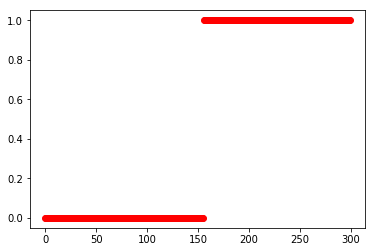

In [546]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

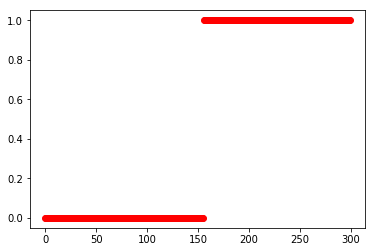

In [547]:
plt.plot(clf.predict(sorted_test[:,1:257]),'ro')
plt.show()

In [662]:
from sklearn import svm
X = scaled[0:1000]
y = mig_rate[0:1000]
regr = svm.SVR(C=1000,epsilon=.01)
regr.fit(X, y)  

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [615]:
testset = np.empty(shape=[0,257])
for i in range(1000,1300):
    testset=np.vstack([testset,np.append(mig_rate[i],scaled[i])])

In [616]:
#testset[:,0] = (testset[:,0] > 0).astype(int)
sorted_test= testset[testset[:,0].argsort()]

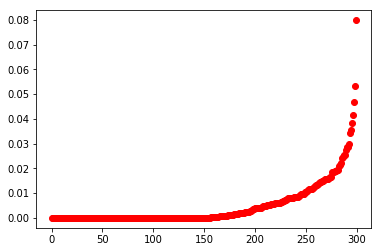

In [617]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

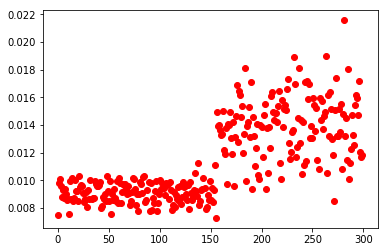

In [663]:
plt.plot(regr.predict(sorted_test[:,1:257]),'ro')
plt.show()

In [584]:
from sklearn.decomposition import KernelPCA

In [585]:
rbf_pca = KernelPCA(n_components=2, kernel = 'rbf', gamma = .0004)

In [586]:
X_red = rbf_pca.fit_transform(trans_norm)

In [587]:
zeros = X_red[(int_mig_rate==0)[0:len(trans_norm)],:]
ones = X_red[(int_mig_rate==1)[0:len(trans_norm)],:]

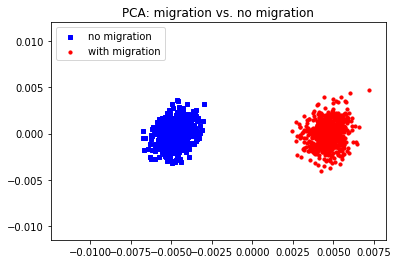

In [588]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(zeros[:,0]*10,zeros[:,1]*10, s=10, c='b', marker="s", label='no migration')
ax1.scatter(ones[:,0]*10,ones[:,1]*10, s=10, c='r', marker="o", label='with migration')
plt.legend(loc='upper left');
plt.title("PCA: migration vs. no migration")
plt.show()

In [592]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(trans_norm,ml_labels.reshape(1,-1)[0])

In [594]:
gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
bst_n_estimators

12

In [595]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=12)
gbrt_best.fit(trans_norm[0:1000], ml_labels.reshape(1,-1)[0][0:1000])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=12, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

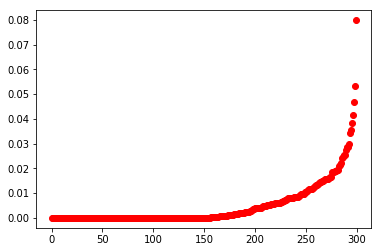

In [596]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

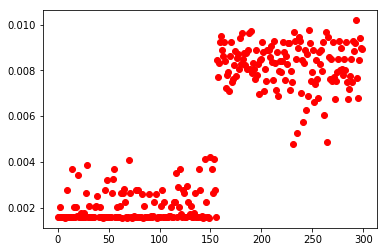

In [597]:
plt.plot(gbrt_best.predict(sorted_test[:,1:257]),'ro')
plt.show()

In [526]:
import h5py
f = h5py.File("test.hdf5", "w")
f.create_dataset("labels", (len(ml_labels),))
f.create_dataset("matrices",(ml_feats.shape),dtype = 'i')
f['labels'][...] = ml_labels.reshape(1,-1)[0]
f['matrices'][...] = ml_feats
f.close()

Try a neural network.

In [664]:
from sklearn.neural_network import MLPRegressor

In [746]:
neuralnet = MLPRegressor(solver='lbfgs',activation='tanh', alpha=1e-10,hidden_layer_sizes=(7,3), random_state=8,max_iter=1000000,
                        tol=1e-10,momentum = 0.3)
X = scaled[0:1000]
y = mig_rate[0:1000]
neuralnet.fit(X,y)

MLPRegressor(activation='tanh', alpha=1e-10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000000, momentum=0.3,
       nesterovs_momentum=True, power_t=0.5, random_state=8, shuffle=True,
       solver='lbfgs', tol=1e-10, validation_fraction=0.1, verbose=False,
       warm_start=False)

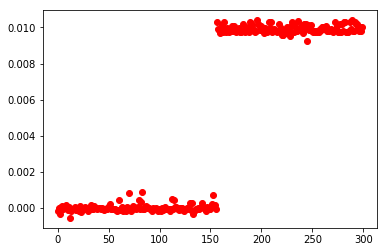

In [747]:
plt.plot(neuralnet.predict(sorted_test[:,1:257]),'ro')
plt.show()

Really strange that these values all come out at the gamma value used here.